In [1]:
%matplotlib inline

## PyTorch: Autograd

source: https://github.com/jcjohnson/pytorch-examples <br>
modified by Sam,Liu

In the above examples, we had to manually implement both the forward and
backward passes of our neural network. Manually implementing the backward pass
is not a big deal for a small two-layer network, but can quickly get very hairy
for large complex networks.

Thankfully, we can use
[automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)
to automate the computation of backward passes in neural networks. 
The **autograd** package in PyTorch provides exactly this functionality.
When using autograd, the forward pass of your network will define a
**computational graph**; nodes in the graph will be Tensors, and edges will be
functions that produce output Tensors from input Tensors. Backpropagating through
this graph then allows you to easily compute gradients.

This sounds complicated, it's pretty simple to use in practice. If we want to
compute gradients with respect to some Tensor, then we set `requires_grad=True`
when constructing that Tensor. Any PyTorch operations on that Tensor will cause
a computational graph to be constructed, allowing us to later perform backpropagation
through the graph. If `x` is a Tensor with `requires_grad=True`, then after
backpropagation `x.grad` will be another Tensor holding the gradient of `x` with
respect to some scalar value.

Sometimes you may wish to prevent PyTorch from building computational graphs when
performing certain operations on Tensors with `requires_grad=True`; for example
we usually don't want to backpropagate through the weight update steps when
training a neural network. In such scenarios we can use the `torch.no_grad()`
context manager to prevent the construction of a computational graph.

### Custom weight updating, custom loss function, Custom ReLu function
Here we use PyTorch Tensors and autograd to implement our two-layer network;
now we no longer need to manually implement the backward pass through the
network:

('loss:', 0.00018372960039414465)


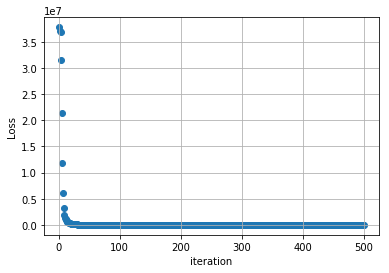

In [15]:
# Code in file autograd/two_layer_net_autograd.py
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and outputs
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Create random Tensors for weights; setting requires_grad=True means that we
# want to compute gradients for these Tensors during the backward pass.
w1 = torch.randn(D_in, H, device=device, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, requires_grad=True)

learning_rate = 1e-6
loss_list = []
for t in range(500):
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    y_pred = x.mm(w1).clamp(min=0).mm(w2)
    
        # Compute loss. Loss is a Tensor of shape (), and loss.item()
    # is a Python number giving its value.
    loss = (y_pred - y).pow(2).sum()
    loss_list.append(loss.item())
    #print(t, loss.item())

# Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # Update weights using gradient descent. For this step we just want to mutate
    # the values of w1 and w2 in-place; we don't want to build up a computational
    # graph for the update steps, so we use the torch.no_grad() context manager
    # to prevent PyTorch from building a computational graph for the updates
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after running the backward pass
        w1.grad.zero_()
        w2.grad.zero_()
print('loss:', loss_list[-1])
plt.scatter(np.linspace(1, 500, num=500) ,loss_list, marker='o')
plt.grid()
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.show()

## PyTorch: nn
Computational graphs and autograd are a very powerful paradigm for defining
complex operators and automatically taking derivatives; however for large
neural networks raw autograd can be a bit too low-level.

When building neural networks we frequently think of arranging the computation
into **layers**, some of which have **learnable parameters** which will be
optimized during learning.

In PyTorch, the `nn` package serves this same purpose. The `nn` package defines a set of
**Modules**, which are roughly equivalent to neural network layers. A Module receives
input Tensors and computes output Tensors, but may also hold internal state such as
Tensors containing learnable parameters. The `nn` package also defines a set of useful
loss functions that are commonly used when training neural networks.

### Define Networks, Official loss function, Official ReLu function
In this example we use the `nn` package to implement our two-layer network:

('loss:', 7.647578968317248e-06)


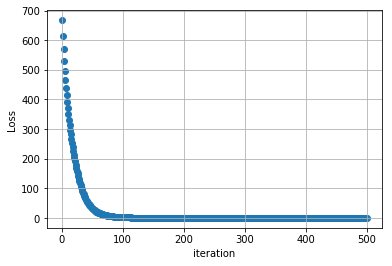

In [29]:
# Code in file nn/two_layer_net_nn.py
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary (differentiable) operations on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

model = TwoLayerNet(D_in, H, D_out)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function. Setting
# reduction='sum' means that we are computing the *sum* of squared errors rather
# than the mean; this is for consistency with the examples above where we
# manually compute the loss, but in practice it is more common to use mean
# squared error as a loss by setting reduction='elementwise_mean'.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
loss_list = []
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the loss.
    loss = loss_fn(y_pred, y)
    #print(t, loss.item())
    loss_list.append(loss.item())
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its data and gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param.data -= learning_rate * param.grad
print('loss:', loss_list[-1])
plt.scatter(np.linspace(1, 500, num=500) ,loss_list, marker='o')
plt.grid()
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.show()
